In [1]:
## Map of the stations.. 
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
%matplotlib inline 
import pandas as pd 
import numpy as np 
import statsmodels.api as st
import statsmodels.formula.api as sfa 
import seaborn as sbn 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as mt 
from sklearn.neighbors import KernelDensity

/home/tadeze/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data pre-processing

In [2]:
## Load daily rainfall data
allrain = pd.read_csv('gpm-tahmo-rain.csv')
allrain.datetime = pd.to_datetime(allrain.datetime)
allrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19251 entries, 0 to 19250
Data columns (total 8 columns):
station     19251 non-null object
year        19251 non-null int64
month       19251 non-null int64
day         19251 non-null int64
tahmo       19251 non-null float64
gpm         19251 non-null float64
datetime    19251 non-null datetime64[ns]
yday        19251 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1.2+ MB


In [3]:
# Only tahmo stations
tahmo_rain = allrain[['station','year','datetime','tahmo']]
tahmo_rain.head(5)

,station,year,datetime,tahmo
0,TA00020,2016,2016-01-01,0.0
1,TA00020,2016,2016-01-02,0.0
2,TA00020,2016,2016-01-03,0.0
3,TA00020,2016,2016-01-04,0.0
4,TA00020,2016,2016-01-05,0.0


In [7]:
def nearby_stations(site_code, k=10, radius=500):
    """
    Return k-nearest stations, given a station name.
    args:
        site_code: station site code.
        k: number of stations. 
        radius: radius of distance in KM
    """
    stations = pd.read_csv("nearest_stations.csv") #Pre-computed value. 
    k_nearest = stations[(stations['from'] == site_code) & (stations['distance'] < radius)]
    k_nearest = k_nearest.sort_values(by=['distance', 'elevation'], ascending=True)[0:k]
    
    return k_nearest

In [8]:
filter_station = lambda stn_name, year: tahmo_rain[(tahmo_rain.station==stn_name) & (tahmo_rain.year==year)] 

In [9]:
# target station 
target_station = "TA00025"
t_station = filter_station(target_station, 2016)

In [11]:
def k_nearby_features(target_station, k=5, year=2016):
    """
    Extract percipitation from k nearby stations. 
    """
    filter_stn = lambda stn_name, year: tahmo_rain[(tahmo_rain.station==stn_name) & (tahmo_rain.year==year)] 
    t_station = filter_stn(target_station, year)
    k_station = nearby_stations(site_code=target_station, k=k,radius=300).to.tolist()
    X = t_station['tahmo'].as_matrix().reshape([-1,1])
    datetime = t_station.datetime.tolist()
    
   # print datetime.shape
    for stt in k_station:
        R = filter_stn(stt,year)[['tahmo']].as_matrix().reshape([-1,1])
        X = np.hstack([X,R])
        
    df = pd.concat([pd.DataFrame(datetime),pd.DataFrame(X)], axis=1)
    df.columns = ["datetime",target_station] + k_station
    
    return df

### Data exploratory 

Task:
Predict the percipitation at a target station using nearby stations. For this task we target the following stations for prediction. 
    
Target stations:
 - TA00025 
 - TA00074
 - TA00077
 
The red markers indicates target stations. 

<img src=images/target-stations.png width=75%>


In [12]:
## Target stations, TA0025, TA00077, TA00074 
t_stn = k_nearby_features(target_station)

In [13]:
t_stn.head(5)

,datetime,TA00025,TA00066,TA00057,TA00020,TA00024,TA00056
0,2016-01-01,0.14,0.20,0.04,0.0,0.16,0.00
1,2016-01-02,0.04,0.08,0.00,0.0,0.18,0.00
2,2016-01-03,0.08,0.00,0.04,0.0,0.14,0.00
3,2016-01-04,3.64,4.39,16.49,0.0,7.49,30.89
4,2016-01-05,0.77,0.48,0.95,0.0,0.88,4.16


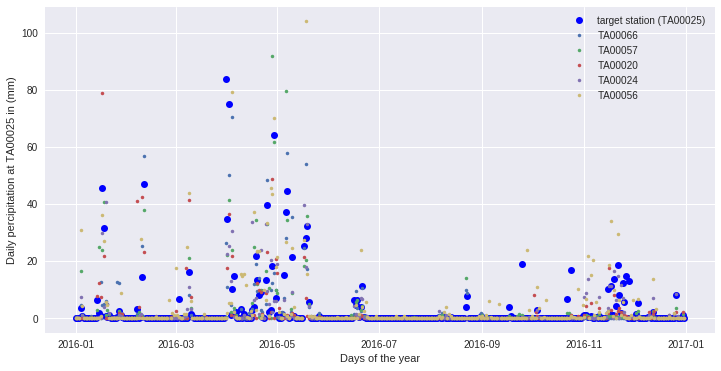

In [14]:
plt.figure(figsize=(12,6))
plt.plot(t_stn.datetime, t_stn[target_station],'ob',label="target station (" + target_station+")")
for i in range(2, 7):
     plt.plot(t_stn.datetime, t_stn.iloc[:,i],'.',label=t_stn.columns[i])
plt.ylabel("Daily percipitation at TA00025 in (mm)")
plt.xlabel("Days of the year")
plt.legend(loc="best")

Histogram of non-zero percipitation at target station 

In [16]:
t_nonzero_perp = np.log(t_stn[t_stn[target_station]>0][target_station])

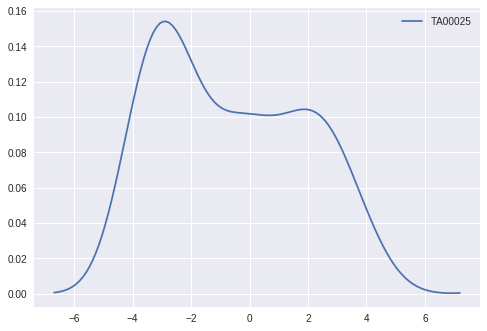

In [18]:
sbn.kdeplot(t_nonzero_perp, shade=False)


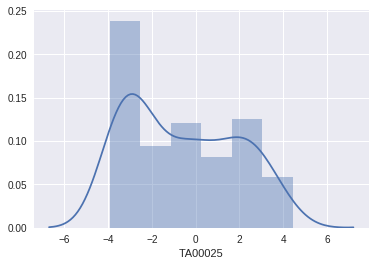

In [376]:
sbn.distplot(t_nonzero_perp, hist=True);

### Fit regression model. 
Logistic regression for rain response. Availability of rain or not indicates as 0/1 prediction. 

In [36]:
t_stn['rain_yes'] = (t_stn[target_station]>0).astype(int)

In [4]:
t_stn.iloc[:,2:-1].head(5)

NameError: name 't_stn' is not defined

In [380]:
formula = "rain_yes~TA00066+TA00057+TA00020+TA00024+TA00056"

In [381]:
m2 = sfa.glm(family=st.families.Binomial(st.families.links.logit), formula=formula, data=t_stn).fit()

In [382]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               rain_yes   No. Observations:                  366
Model:                            GLM   Df Residuals:                      360
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 23 May 2018   Deviance:                       363.65
Time:                        13:46:11   Pearson chi2:                     328.
No. Iterations:                    11                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8638      0.146     -5.932      0.000      -1.149      -0.578
TA00066        1.4307      0.597      2.396      0.017       0.260       2.601
TA00057        1.4002      0.467      3.001      0.003       0.486       2.315
TA00020        0.0106      0.073      0.144      0.885      -0.133       0.154
TA00024        1.3076      0.566      2.308      0.021       0.197       2.418
TA00056        0.0098      0.040      0.241      0.809      -0.069       0.089
==============================================================================
"""

In [389]:
i = np.argsort(m2.fittedvalues).tolist()

In [394]:
observed_value = t_stn.iloc[:,2:-1].mean(axis=1)

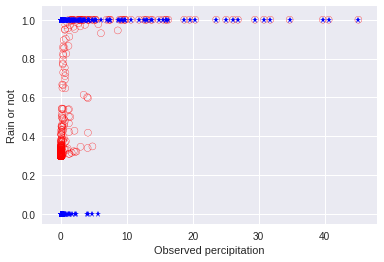

In [397]:

plt.plot(observed_value[i],t_stn['rain_yes'][i],'*b')
plt.scatter(observed_value[i], m2.fittedvalues[i],facecolor='none',edgecolors='r')
plt.xlabel('Observed percipitation')
plt.ylabel("Rain or not")
## x-axsi k-station average. 

In [317]:
pp = m2.fittedvalues
ll = t_stn['rain_yes']
fpr_rt_lm, tpr_rt_lm, _ = mt.roc_curve( ll, pp)
auc_score = mt.auc(fpr_rt_lm, tpr_rt_lm, reorder=True)

In [318]:
auc_score

0.8654592689918776

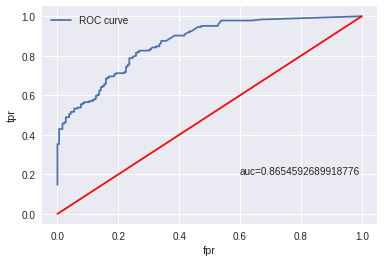

In [319]:
plt.clf()
plt.plot(fpr_rt_lm, tpr_rt_lm, label='ROC curve')
plt.ylabel("tpr")
plt.xlabel("fpr")
plt.plot(range(0,2),range(0,2),'-r')
plt.text(0.6, 0.2,"auc="+str(auc_score))
plt.legend(loc='best')


In [240]:
##  Use the m2 predictiosn for probability of rain as the weights in fitting the linear model. 

In [399]:
eps = .1
weights = m2.fittedvalues
for cln in t_stn.columns[1:-1]:
    t_stn['l'+cln] = np.log(t_stn[cln] + eps)

In [411]:
t_stn.head(5)

,datetime,TA00025,TA00066,TA00057,TA00020,TA00024,TA00056,rain_yes,lTA00025,lTA00066,lTA00057,lTA00020,lTA00024,lTA00056
0,2016-01-01,0.14,0.20,0.04,0.0,0.16,0.00,1,-1.427116,-1.203973,-1.966113,-2.302585,-1.347074,-2.302585
1,2016-01-02,0.04,0.08,0.00,0.0,0.18,0.00,1,-1.966113,-1.714798,-2.302585,-2.302585,-1.272966,-2.302585
2,2016-01-03,0.08,0.00,0.04,0.0,0.14,0.00,1,-1.714798,-2.302585,-1.966113,-2.302585,-1.427116,-2.302585
3,2016-01-04,3.64,4.39,16.49,0.0,7.49,30.89,1,1.319086,1.501853,2.808800,-2.302585,2.026832,3.433665
4,2016-01-05,0.77,0.48,0.95,0.0,0.88,4.16,1,-0.139262,-0.544727,0.048790,-2.302585,-0.020203,1.449269


In [409]:
m3= LinearRegression()
m3.fit(X=t_stn.iloc[:,9:].as_matrix(), y=t_stn.iloc[:,9].as_matrix(), sample_weight=weights.as_matrix())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [405]:
fitted = m3.predict(t_stn.iloc[:,9:].as_matrix())

In [406]:
residuals = (fitted - t_stn.iloc[:,9].as_matrix()).reshape([-1,1])

/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


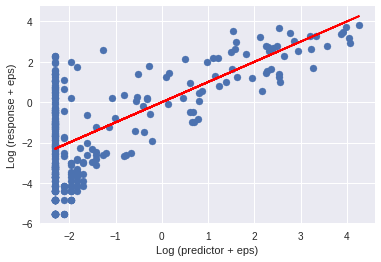

In [419]:
plt.scatter(t_stn.iloc[:,9], np.log(observed_value))
plt.plot(t_stn.iloc[:,9], fitted,'-r')
plt.xlabel('Log (predictor + eps)')
plt.ylabel('Log (response + eps)')

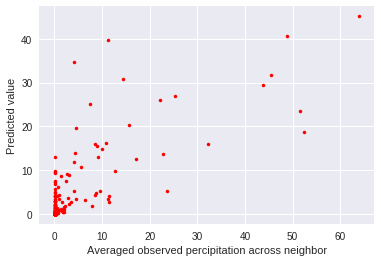

In [426]:
# Show fitted versus observed in original units
plt.plot(np.exp(fitted - eps), observed_value, '.r')
plt.ylabel('Predicted value')
plt.xlabel("Averaged observed percipitation across neighbor")

#plot(exp(m3$fitted.values - eps), rain.df$KENT, xlab="Predicted KENT", ylab = "Observed KENT")

# And on a log scale
#plot(m3$fitted.values, rain.df$LEKENT, xlab="Predicted log(KENT + epsilon)", ylab = "Observed log(KENT + epsilon)")


In [442]:
import scipy.stats as stat

In [446]:
# compare the log-scale residuals
xbar = np.mean(residuals)
s = np.std(residuals)
x = np.arange(-4, 4, 0.01)
#normal= np.random.
#plot(density(m3$residuals))
#points(x, normal, pch=".", col="red")
nrm = stat.norm(xbar, s)
d = nrm.pdf(x)

In [437]:
d

In [340]:
# Density of the residuals 
kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(residuals)


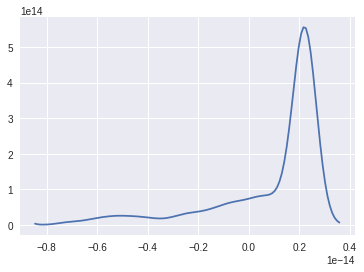

In [345]:
sbn.distplot(residuals,hist=False)

 Smear out the rain over multiple days.
 - flatline fault and percipitation. 
 - K-windwos analysis... large 

In [479]:
def mixl(x, p1, preditions, kde):
    result = (1-p1)*(observations==0) + \
    p1*kde.score_samples((predictions-np.log(observations + eps)))/abs(observations+eps)
    return result

In [39]:
## Insert faults for the 2017 data. 